#### Setup

In [3]:
! pip install wand

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 3.2 MB/s eta 0:00:00 MB/s eta 0:00:01


In [3]:
! brew uninstall imagemagick
! brew install imagemagick@6
! brew unlink imagemagick
! brew link imagemagick@6 --force
! echo 'export MAGICK_HOME="/usr/local/opt/imagemagick@6/lib"' >> ~/.bash_profile
! echo 'export PATH="/usr/local/opt/imagemagick@6/bin:$PATH"' >> ~/.bash_profile

! source ~/.bash_profile

Uninstalling /opt/homebrew/Cellar/imagemagick/7.1.0-51... (805 files, 30.8MB)
==> Downloading https://ghcr.io/v2/homebrew/core/imagemagick/6/manifests/6.9.12-
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/imagemagick/6/blobs/sha256:3681
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Pouring imagemagick@6--6.9.12-66.arm64_monterey.bottle.tar.gz
==> Caveats
imagemagick@6 is keg-only, which means it was not symlinked into /opt/homebrew,
because this is an alternate version of another formula.

If you need to have imagemagick@6 first in your PATH, run:
  echo 'export PATH="/opt/homebrew/opt/imagemagick@6/bin:$PATH"' >> ~/.zshrc

For compilers to find imagemagick@6 you may need to set:
  export LDFLAGS="-L/opt/homebrew/opt/imagemagick@6/lib"
  export CPPFLAGS="-I/opt/homebrew/opt/imagemagick@6

In [ ]:
! convert -list font

## Font Generation

In [82]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from wand.color import Color
from wand.image import Image
from wand.drawing import Drawing
from wand.compat import nested
import shutil
import pandas as pd

In [6]:
# Charatcters 
language = 'abcdefghijklmnopqrstuvwxyz'
language_upper = language.upper()
language += language_upper
language += '0123456789'

assert len(language) == 26 * 2 + 10 
language = language_upper
language

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [425]:
# Fonts
handwritten_fonts = ['Herculanum', 'Annai MN', 'Bradley Hand', 'Brush Script MT', 'Chalkboard',
             'Comic Sans MS', 'Luminary', 'Noteworthy', 'Papyrus', 'Party LET', 'Savoye LET', 
             'Sign Painter', 'Skia', 'Snell Roundhand', 'Times New Roman', 'Trattatello', 'Zapfino']
typed_fonts = ['Arial', 'Arial Black', 'Arial Narrow', 'Arial Rounded MT Bold', 'Copperplate', 'Courier New', 'Helvetica',
              'Impact', 'Lucinda Grande', 'Microsoft Sans Serif', 'Tahoma', 'Verdana', 'Menlo', 'Didot', 'Copperplate', 'Avenir', 'Futura']

fonts = handwritten_fonts + typed_fonts 
# fonts = ['Chalkboard']

In [426]:
# resolution
width=200
height=200
font_size=100
background = Color('white')
foreground=Color('rgb(0, 0, 0)')

In [427]:
language

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [428]:
def delete(language, language_upper):
    for c in language:
        if c in language_upper:
            if os.path.exists(f'{c}{c}'):
                shutil.rmtree(f'{c}{c}')
        else:
            if os.path.exists(c):
                shutil.rmtree(f'{c}')

In [429]:
def generate(fonts, language, language_upper, width=200, height=200, font_size=100, background=Color('white'), foreground=Color('rgb(0,0,0)')):
    for f in tqdm(fonts):
        for c in language:
            if c in language_upper:
                if not os.path.exists(f'{c}{c}'):
                    os.mkdir(f'{c}{c}')
                filename = os.path.join(f'{c}{c}', f'{f}.png')
            else:
                if not os.path.exists(c):
                    os.mkdir(f'{c}')
                filename = os.path.join(f'{c}', f'{f}.png')

            with Drawing() as draw:
                with Image(width=width, height=height, background=background) as img:
                    draw.font_family = f
                    draw.font_size = font_size
                    draw.push()
                    draw.fill_color = foreground
                    draw.text(0,int(img.height/2), c)
                    draw.pop()
                    draw(img)
                    if os.path.exists(filename):
                        os.unlink(filename)
                    img.save(filename='tmp.png')

                    img = cv2.imread('tmp.png')

                    os.unlink('tmp.png')
                    ys, xs = np.where(np.all(img == (0, 0, 0), axis=-1))

                    cropped = img[min(ys):max(ys)+1, min(xs):max(xs)+1]
                    cv2.imwrite(filename, cropped)
            

In [430]:
generate(fonts, language, language_upper)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:05<00:00,  5.87it/s]


#### Inference

##### Functions

In [431]:
import matplotlib.pyplot as plt
def show(*img):
    for i in img:
        plt.imshow(i, cmap='gray')
        plt.show()

# Read
def read(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def bin(img, bins=10, min_diff=10):
    count, division = np.histogram(img, bins)
    diff_series = pd.Series(count).diff()
    
    first_histogram_reduction_index = diff_series[(diff_series < 0) & (np.abs(diff_series) > min_diff)].index[0]
    threshold = division[first_histogram_reduction_index+1]
        
    _, img = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
    return img

def bin2(img):
    return cv2.threshold(img, 0, 255, cv2.THRESH_BINARY +cv2.THRESH_OTSU)[1]

def neg(img):
    return 255 - img

def redraw_contours(img, thickness=16): 
    # Find contours and redraw
    contours, hierarchy = cv2.findContours(image=img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                      
    # draw contours on the original image
    image_copy = img.copy()
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(255, 255, 255), thickness=thickness, lineType=cv2.LINE_AA)
    return image_copy

def components(img, min_area=1000):
    # Connected components
    output = cv2.connectedComponentsWithStats(img, 4, cv2.CV_32S)
    num_letters = output[0]
    letters = output[1]
    stats = output[2]
    centroids = output[3]

    letter_imgs = []
    ## Sort letters + area check
    image_copy = img.copy()
    for l in range(1, num_letters):
        minx = stats[l, cv2.CC_STAT_LEFT]
        maxx = stats[l, cv2.CC_STAT_WIDTH] + minx
        miny = stats[l, cv2.CC_STAT_TOP] 
        maxy = stats[l, cv2.CC_STAT_HEIGHT] + miny
        area = stats[l, cv2.CC_STAT_AREA]
        if area < min_area:
            continue

        cropped_img = img[miny:maxy+1, minx: maxx+1].copy()
        letter_imgs.append((cropped_img, minx))
        cv2.rectangle(image_copy,(minx, miny), (maxx, maxy) ,(255, 255, 255), 3)

    sorted_img_list = sorted(letter_imgs, 
       key=lambda x: x[1])
    return [s[0] for s in sorted_img_list]

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def resize(img, size=(100, 100)):
    return cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)

def erode(img, it=1):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.erode(img, kernel, iterations=it)

def dilate(img, it=1):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.dilate(img, kernel, iterations=it)

In [432]:
def pipeline(x, show_steps=False):
    img = read(x)
    img_bin = bin(img)
    
    # # Denoise
    # img_bin = bin(cv2.blur(img_bin,(2,2)))
    
    # Neg
    img_bin_neg = neg(img_bin)
    
    # Adaptive thickening
#     thickness = 4
#     redraw = redraw_contours(img_bin_neg, thickness=thickness)
#     letter_boxes = components(redraw)
#     n_letters = len(letter_boxes)
    
#     tmp_letters = n_letters
#     # print(n_letters)
#     while True:
#         thickness *= 2
#         redraw = redraw_contours(img_bin_neg, thickness=thickness)
#         letter_boxes = components(redraw)
#         tmp_letters = len(letter_boxes)
#         print(tmp_letters)
        
#         if tmp_letters < n_letters:
#             break
#         elif tmp_letters >= n_letters:
#             n_letters = tmp_letters
        
#     thickness//=2
#     redraw = redraw_contours(img_bin_neg, thickness=thickness)

    # Redraw contours to make stronger letters
    redraw = redraw_contours(img_bin_neg)
    
    # Find components
    letter_boxes = components(redraw)

    letter_boxes = [neg(l) for l in letter_boxes]
    if show_steps:
        show(img)
        show(img_bin)
        show(img_bin_neg)
        show(redraw)
        for l in letter_boxes:
            show(l)
            
    return letter_boxes

In [433]:
def classify(letter_img, inference_size=(200, 200), _filter='.png'):
    results = []
    for c in language:
        if c in language_upper:
            fld = f'{c}{c}'
        else:
            fld = f'{c}'
            
        files = [x for x in os.listdir(fld) if x.endswith(_filter)]
        letter_img_r = bin(cv2.resize(letter_img, inference_size, interpolation=cv2.INTER_NEAREST))
        for f in files: 
            ## TODO Check and possibly binarize all when reading
            path = os.path.join(fld, f)
            img_f = bin(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
            img_fr = bin(cv2.resize(img_f, inference_size, interpolation=cv2.INTER_NEAREST))
            
            iou = (letter_img_r//255 & img_fr//255).sum() / (letter_img_r//255 | img_fr//255).sum()
            results.append( {
                'char': c,
                'font': f,
                'iou': iou
            })
    results = pd.DataFrame(results)
    
    # selection
    g = results.groupby('char')['iou'].mean()
    character = g[g == g.max()].index[0]
    return character, results

In [434]:
def ocr(path, show_steps=False, return_dfs=False):
    letters = pipeline(path, show_steps=show_steps)
    if return_dfs==False:
        return [classify(l)[0] for l in letters]
    else:
        return [classify(l) for l in letters]

##### Best font search

In [2222]:
expectations = {
    'test.png' : "TEST",
    'tactical.png': "TACTICAL",
    'digital.png': "DIGITAL",
    'ocr.png': "OCR",
    'team.png': "TEAM",
    'processing.png': "PROCESSING",
}

In [2167]:
test_fonts = handwritten_fonts + typed_fonts
font_results = {}
for f in tqdm(test_fonts):
    count = 0
    delete(language, language_upper)
    generate([f], language, language_upper)
    for path, exp_result in expectations.items():
        res = ''.join(ocr(path))
        for i in range(len(exp_result)):
            if res[i] == exp_result[i]:
                count+=1
    font_results[f] = count
font_results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [1:08:36<00:00, 121.08s/it]


{'Herculanum': 23,
 'Annai MN': 21,
 'Bradley Hand': 24,
 'Brush Script MT': 16,
 'Chalkboard': 28,
 'Comic Sans MS': 28,
 'Luminary': 21,
 'Noteworthy': 15,
 'Papyrus': 19,
 'Party LET': 9,
 'Savoye LET': 3,
 'Sign Painter': 21,
 'Skia': 22,
 'Snell Roundhand': 3,
 'Times New Roman': 23,
 'Trattatello': 26,
 'Zapfino': 4,
 'Arial': 21,
 'Arial Black': 26,
 'Arial Narrow': 20,
 'Arial Rounded MT Bold': 23,
 'Copperplate': 27,
 'Courier New': 9,
 'Helvetica': 19,
 'Impact': 21,
 'Lucinda Grande': 21,
 'Microsoft Sans Serif': 19,
 'Tahoma': 28,
 'Verdana': 26,
 'Menlo': 20,
 'Didot': 18,
 'Avenir': 21,
 'Futura': 25}

In [2174]:
pd.DataFrame([font_results]).T.sort_values(by=0)

,0
Savoye LET,3
Snell Roundhand,3
Zapfino,4
Courier New,9
Party LET,9
Noteworthy,15
Brush Script MT,16
Didot,18
Microsoft Sans Serif,19
Papyrus,19


### NN

In [435]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [436]:
def augment(train_images, train_labels, depth=2):
    res_images = []
    res_labels = []
    for i in range(train_images.shape[0]):
        img = train_images[i]
        l = train_labels[i]
        for it in range(0, depth):
            img_x = erode(img, it=it)
            res_images.append(img_x)
            res_labels.append(l)
        for it in range(0, depth):
            img_x = dilate(img, it=it)
            res_images.append(img_x)
            res_labels.append(l)
    return np.stack(res_images),np.array(res_labels)  

In [437]:
## Augment Data
size = 64
epochs = 20

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(language)))
model.summary()

import glob

image_paths = sorted(glob.glob("*/*.png"))
train_labels = np.array(list(range(26)))
classes = sorted(set([i[:i.index('/')] for i in image_paths]))
classes_fmap = dict(zip(classes, train_labels))
classes_imap = dict(zip(train_labels, classes))

train_images = [bin(resize(read(x), size=(size, size)))//255 for x in image_paths]
train_labels = np.stack([classes_fmap[i[:i.index('/')]] for i in image_paths])
train_images = np.stack(train_images)

# Augment images 
train_images_augmented, train_labels_augmented = augment(train_images, train_labels, depth=2)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images_augmented, train_labels_augmented, epochs=epochs)


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_99 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (None, 12, 12, 64)        36928     
                                                                 
 flatten_32 (Flatten)        (None, 9216)            

In [442]:

def classify_nn_augmented(letter_img, inference_size=(size, size), _filter='.png'):
    # Add dilation to inference
    letter_imgs_augmented = [dilate(letter_img, it=i) for i in range(3)]
    letter_imgs_augmented += [erode(letter_img, it=i) for i in range(3)]
    
    characters = []
    for i, letter_img in enumerate(letter_imgs_augmented):
        letter_img_res = bin(resize(letter_img, inference_size))//255
        letter_img_tensor = np.stack([letter_img_res])

        results = model.predict(letter_img_tensor)
        char_idx = np.argmax(results)
        character = classes_imap[char_idx][0]
        characters.append({'char': character, 'dilate_it': i, 'result': np.max(results)})
        
    characters = pd.DataFrame(characters)
    return characters['char'].mode().values[0]

def classify_nn(letter_img, inference_size=(size, size), _filter='.png'):

    letter_img_res = bin(resize(letter_img, inference_size))//255
    letter_img_tensor = np.stack([letter_img_res])

    results = model.predict(letter_img_tensor)
    char_idx = np.argmax(results)
    character = classes_imap[char_idx][0]
    return character, results

def ocr_nn(path, show_steps=False, return_dfs=False):
    letters = pipeline(path, show_steps=show_steps)
    if return_dfs==False:
        return [classify_nn(l)[0] for l in letters]
    else:
        return [classify_nn(l) for l in letters]

#### Tests NN

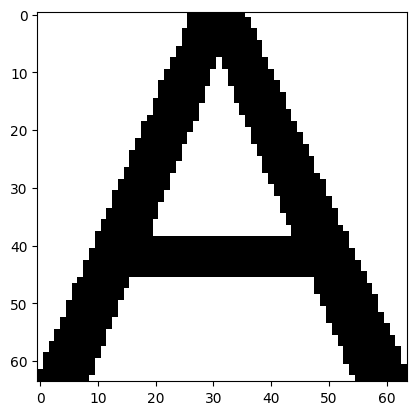

In [443]:
show(255 * train_images[0])

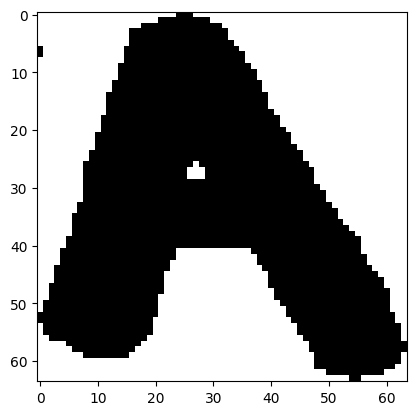

In [444]:
show(resize(255 * (pipeline('digital.png')[-2]//255), (size, size)))

In [445]:
num_correct = 0
num_total = 0

for t in ['test.png', 'ocr.png', 'tactical.png', 'digital.png', 'team.png', 'processing.png']:
    label = t[:t.index('.')].upper()
    num_total += len(label)
    
    result = ''.join(ocr_nn(t))    
    for i in range(len(label)):
        if label[i] == result[i]:
            num_correct+=1
        
    print(result)
print('Accuracy:', num_correct/num_total)

1/1 [==============================] - 0s 10ms/step
TEST
1/1 [==============================] - 0s 10ms/step
OCR
1/1 [==============================] - 0s 10ms/step
TACTICAL
1/1 [==============================] - 0s 10ms/step
DIGITAL
1/1 [==============================] - 0s 10ms/step
TEAM
1/1 [==============================] - 0s 9ms/step
PROCESSXNQ
Accuracy: 0.9444444444444444


### Tests

In [406]:
num_correct = 0
num_total = 0

for t in ['test.png', 'ocr.png', 'tactical.png', 'digital.png', 'team.png', 'processing.png']:
    label = t[:t.index('.')].upper()
    num_total += len(label)
    
    result = ''.join(ocr(t))    
    for i in range(len(label)):
        if label[i] == result[i]:
            num_correct+=1
        
    print(ocr(t))
print('Accuracy:', num_correct/num_total)

['T', 'F', 'S', 'T']
['O', 'C', 'R']
['T', 'A', 'C', 'T', 'T', 'C', 'A', 'L']
['Q', 'T', 'C', 'T', 'T', 'A', 'L']
['T', 'E', 'A', 'A']
['P', 'X', 'O', 'C', 'C', 'S', 'S', 'X', 'X', 'A']
Accuracy: 0.6666666666666666


In [378]:
ocr('test.png')

['T', 'F', 'S', 'T']

In [379]:
ocr('tactical.png', show_steps=False)

['T', 'A', 'C', 'T', 'T', 'C', 'A', 'L']

In [86]:
ocr('digital.png', show_steps=False)

['D', 'I', 'C', 'I', 'T', 'A', 'L']

In [87]:
ocr('ocr.png', show_steps=False)

['O', 'C', 'R']

In [88]:
ocr('team.png', show_steps=False)

['T', 'E', 'A', 'A']

In [89]:
ocr('processing.png', show_steps=False)

['F', 'R', 'D', 'C', 'F', 'S', 'S', 'I', 'X', 'A']